In [61]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [62]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [63]:
series = np.sin(0.1*np.arange(200)) #+ np.random.randn(200)*0.1

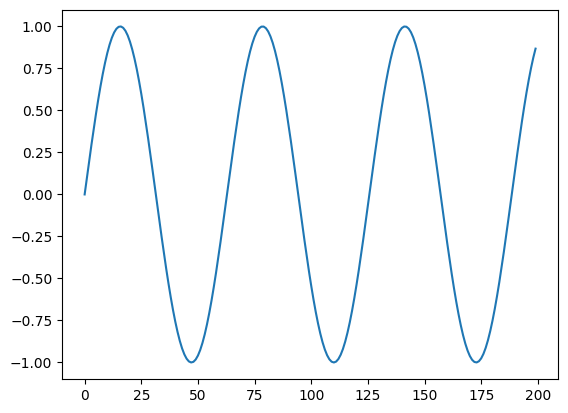

In [64]:
plt.plot(series)
plt.show()

In [65]:
# Create Data Set
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)

## Analyze Data

In [66]:
X.shape

(190, 10)

In [67]:
N = len(X)
N

190

In [68]:

Y.shape

(190,)

## Split Data


In [69]:
validation_index = N//2
X_train = X[:-validation_index]
X_valid = X[-validation_index:]
Y_train = Y[:-validation_index]
Y_valid = Y[-validation_index:]

X_train.shape, Y_train.shape

((95, 10), (95,))

## Create Model

In [70]:
i = Input(shape=X[0].shape)

x = Dense(1)(i)

model = Model(i, x)

model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.1),
)

r = model.fit(
  X_train, Y_train,
  validation_data=(X_valid, Y_valid),
  epochs=80,
  verbose=0,
)

## Evaluate Model Performance

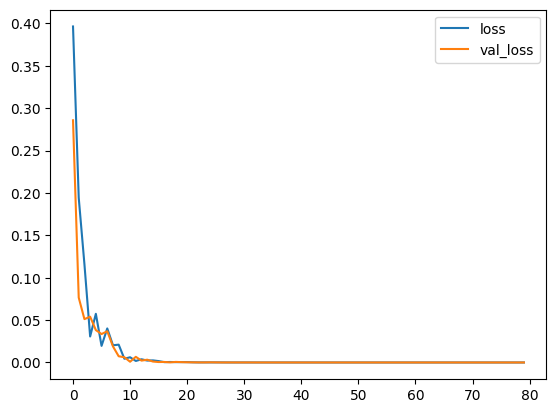

In [71]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

## Wrong Forecasting — Using True Targets

In [72]:
validation_target = Y_valid
validation_predictions = []

# index of first validation input
i = -validation_index

while len(validation_predictions) < len(validation_target):
  one_dim_input = X[i]
  two_dim_input = one_dim_input.reshape(1, -1)
  two_dim_output = model.predict(two_dim_input, verbose=0)
  one_dim_output = two_dim_output[0][0]
  validation_predictions.append(one_dim_output)
  i += 1

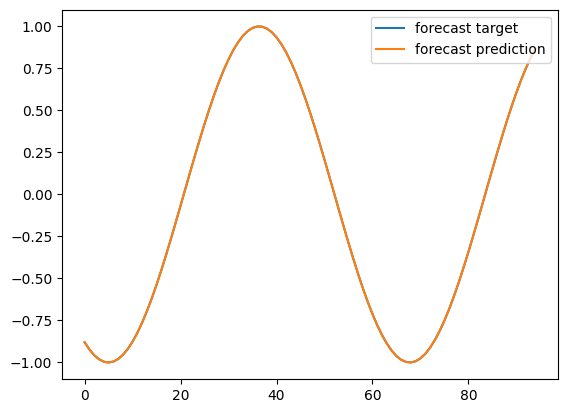

In [73]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Correct Way of Forecasting

In [74]:
validation_target = Y[-validation_index:]
validation_predictions = []

# first validation input is the ONLY data from the validation set that we use. We then feed back in successive predictions to see how accurately we can roll forward from here.
last_x = X[-validation_index] # 1D array of 10 values (len T) of the first validation feature set
last_x

array([-0.07515112, -0.17432678, -0.27176063, -0.36647913, -0.45753589,
       -0.54402111, -0.62507065, -0.69987469, -0.76768581, -0.82782647])

In [75]:
while len(validation_predictions) < len(validation_target):
  one_dim_input = last_x
  two_dim_input = one_dim_input.reshape(1, -1)
  two_dim_output = model.predict(two_dim_input, verbose=0)
  one_dim_output = two_dim_output[0][0]

  validation_predictions.append(one_dim_output)

  last_x = np.roll(last_x, -1) # shift all values to the left
  last_x[-1] = one_dim_output # replace the last value with the output

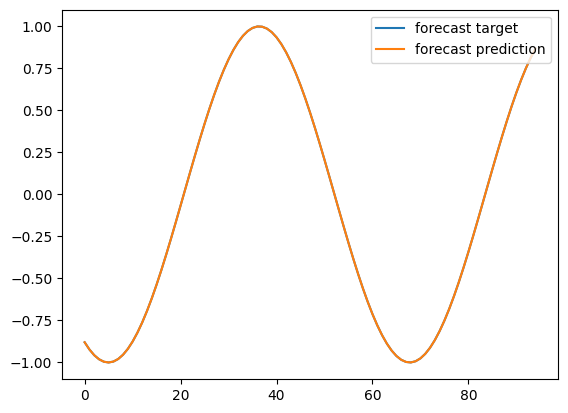

In [76]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()